# Isolation‑Forest Family on Three Public Datasets (CreditCard, AnnThyroid, Shuttle)
**Aisha Tahir**

This notebook is **self-contained** and uses only public, no-credential datasets:
- **Credit Card Fraud (2013)** — via OpenML mirror
- **AnnThyroid** — via OpenML
- **Shuttle** — via OpenML

It fetches datasets, normalizes schema/labels (especially for CreditCard), runs IF/EIF/DIF baselines, saves logs, and draws curves.

## Abstract
We evaluate Isolation Forest (IF), Extended Isolation Forest (EIF, fallback to IF when the `eif` package is absent), and a lightweight Deep Isolation Forest (DIF; random MLP embedding + IF) on three classic fraud/anomaly datasets. We focus on ROC-AUC, PR-AUC, Recall@k, and Recall@FPR=1\%. The notebook is robust to minor schema/label variations in the CreditCard dataset.

## 1. Introduction
Anomaly detection is valuable for fraud data due to severe class imbalance and delayed labels. Isolation-based approaches are attractive for their scalability and minimal assumptions.

## 2. Related Work (2020–2025)
- Extended Isolation Forest (EIF)
- Deep Isolation Forest (DIF)
- Interpretability for isolation forests (e.g., ExIFFI)
- Hyperparameter/meta-heuristic tuning


## 3. Methodology
**Models:** IF (scikit-learn), EIF (if `eif` available), DIF (random-embedding + IF).  
**Metrics:** ROC-AUC, PR-AUC, Recall@k (k=5\%), Precision@k, Recall@FPR=1\%.  
**Splits:** Temporal for CreditCard (if `Time` exists; else index), stratified for the others.

In [1]:
import os, math, time, warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
warnings.filterwarnings('ignore')

try:
    from eif import iForest as EIFImpl  # optional
except Exception:
    EIFImpl = None

RNG_SEED = 42
np.random.seed(RNG_SEED)
plt.rcParams['figure.dpi'] = 110


In [2]:
def safe_ratio(num, den):
    den = max(1, int(den)); return num/den
def recall_at_k(y_true, scores, k_frac=0.05):
    n = len(scores); k = max(1, int(math.ceil(k_frac * n)))
    idx = np.argsort(scores)[::-1][:k]
    y = np.asarray(y_true)[idx]
    return float((y == 1).mean())
def precision_at_k(y_true, scores, k_frac=0.05):
    n = len(scores); k = max(1, int(math.ceil(k_frac * n)))
    idx = np.argsort(scores)[::-1][:k]
    y = np.asarray(y_true)[idx]
    tp = int((y == 1).sum()); return float(tp / k)
def recall_at_fpr(y_true, scores, target_fpr=0.01):
    order = np.argsort(scores)[::-1]; y = np.asarray(y_true)[order]
    pos = int((y==1).sum()); neg = int((y==0).sum())
    fp = tp = 0; best = 0.0
    for yi in y:
        if yi == 1: tp += 1
        else: fp += 1
        fpr = safe_ratio(fp, neg); tpr = safe_ratio(tp, pos)
        if fpr <= target_fpr: best = max(best, tpr)
    return float(best)
def base_metrics(y_true, scores):
    y = np.asarray(y_true); s = np.asarray(scores)
    return {'roc_auc': float(roc_auc_score(y, s)), 'pr_auc': float(average_precision_score(y, s))}


In [3]:
class IFWrapper:
    def __init__(self, **kwargs):
        self.model = IsolationForest(random_state=RNG_SEED, **kwargs)
    def fit(self, X): self.model.fit(X); return self
    def score_samples(self, X): return -self.model.score_samples(X)

class EIFWrapper:
    def __init__(self, n_trees=300, sample_size=512):
        self.n_trees = n_trees; self.sample_size = sample_size
        self.scaler = StandardScaler(); self.impl = EIFImpl; self.fallback = None
    def fit(self, X):
        Xs = self.scaler.fit_transform(X)
        if self.impl is None:
            self.fallback = IFWrapper(n_estimators=self.n_trees, max_samples=self.sample_size).fit(Xs)
        else:
            self.model = self.impl(Xs, ntree=self.n_trees, sample_size=self.sample_size)
        return self
    def score_samples(self, X):
        Xs = self.scaler.transform(X)
        if self.impl is None: return self.fallback.score_samples(Xs)
        return np.asarray(self.model.codisp(Xs))

class RandomMLP:
    def __init__(self, in_dim, latent_dim=32, n_hidden_layers=1, seed=RNG_SEED):
        rs = np.random.RandomState(seed); self.ws=[]; self.bs=[]; d=in_dim
        for _ in range(n_hidden_layers):
            W = rs.normal(0, 1/np.sqrt(d), size=(d, latent_dim)); b = rs.normal(0, 0.01, size=(latent_dim,))
            self.ws.append(W); self.bs.append(b); d = latent_dim
        self.Wz = rs.normal(0, 1/np.sqrt(d), size=(d, latent_dim)); self.bz = rs.normal(0, 0.01, size=(latent_dim,))
    def forward(self, X):
        H = X
        for W,b in zip(self.ws, self.bs): H = np.maximum(H@W + b, 0)
        return H@self.Wz + self.bz

class DIFWrapper:
    def __init__(self, latent_dim=32, n_hidden_layers=1, n_estimators=300, max_samples=512):
        self.embed=None; self.latent_dim=latent_dim; self.n_hidden_layers=n_hidden_layers
        self.iforest = IsolationForest(n_estimators=n_estimators, max_samples=max_samples, random_state=RNG_SEED)
    def fit(self, X):
        self.embed = RandomMLP(X.shape[1], self.latent_dim, self.n_hidden_layers)
        Z = self.embed.forward(X); self.iforest.fit(Z); return self
    def score_samples(self, X):
        Z = self.embed.forward(X); return -self.iforest.score_samples(Z)


## 4. Datasets (OpenML only)

### 4A. Fetch datasets
- CreditCard via OpenML `data_id` or by name
- AnnThyroid via OpenML (`thyroid-ann`)
- Shuttle via OpenML (`shuttle`)

In [4]:
# %pip install openml --quiet  # uncomment when running locally
from sklearn.datasets import fetch_openml

def fetch_creditcard_openml(out_csv='data/raw/creditcard.csv', data_id=46455):
    try:
        Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        Xy = fetch_openml(data_id=data_id, as_frame=True)
        df = Xy.frame
        # Align label name to 'Class' if needed
        if 'Class' not in df.columns:
            target = Xy.target_names[0] if getattr(Xy,'target_names',[]) else 'Class'
            if target in df.columns and target!='Class': df = df.rename(columns={target:'Class'})
        df.to_csv(out_csv, index=False)
        print('[OK] Saved CreditCard to', out_csv, 'shape=', df.shape)
        return out_csv
    except Exception as e:
        print('[ERROR] CreditCard OpenML fetch failed:', e); return None

def fetch_openml_to_csv(name: str=None, target_col: str=None, normal_label=None, out_csv: str='data/raw/tmp.csv', data_id: int=None):
    try:
        Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        Xy = fetch_openml(name=name, data_id=data_id, as_frame=True)
        df = Xy.frame.copy()
        tgt = target_col or (Xy.target_names[0] if getattr(Xy,'target_names',[]) else df.columns[-1])
        if tgt not in df.columns: raise ValueError(f'Target {tgt} not found in {name}.')
        y = df[tgt]
        if normal_label is not None:
            label = (y != normal_label).astype(int)
        else:
            vc = y.value_counts(); normal = vc.idxmax(); label = (y != normal).astype(int)
        X = df.drop(columns=[tgt]).copy(); X['label'] = label.values
        X.to_csv(out_csv, index=False)
        print(f'[OK] Saved {name or data_id} to {out_csv} shape=', X.shape, 'anomaly_rate=', round(X.label.mean(),4))
        return out_csv
    except Exception as e:
        print('[ERROR] OpenML fetch failed for', name or data_id, ':', e); return None

paths = {}
paths['creditcard'] = fetch_creditcard_openml()
paths['annthyroid'] = fetch_openml_to_csv(name='thyroid-ann', normal_label='1', out_csv='data/raw/annthyroid.csv')
paths['shuttle'] = fetch_openml_to_csv(name='shuttle', target_col='class', normal_label='1', out_csv='data/raw/shuttle.csv')
paths

[OK] Saved CreditCard to data/raw/creditcard.csv shape= (28480, 31)
[OK] Saved thyroid-ann to data/raw/annthyroid.csv shape= (3772, 22) anomaly_rate= 0.9753
[OK] Saved shuttle to data/raw/shuttle.csv shape= (58000, 10) anomaly_rate= 0.214


{'creditcard': 'data/raw/creditcard.csv',
 'annthyroid': 'data/raw/annthyroid.csv',
 'shuttle': 'data/raw/shuttle.csv'}

### 4B. Normalize CreditCard schema/labels (if needed)
Some OpenML mirrors have lowercase column names or string labels (e.g., `'otherwise'`). This step coerces to the expected schema (`Time, V1..V28, Amount, Class`) and converts labels to 0/1.

In [5]:
def normalize_creditcard_schema(df):
    # Rename lowercase variants to canonical
    rename_map = {}
    for c in df.columns:
        lc = str(c).lower().strip()
        if lc == 'time': rename_map[c] = 'Time'
        elif lc == 'amount': rename_map[c] = 'Amount'
        elif lc == 'class': rename_map[c] = 'Class'
        elif lc.startswith('v') and lc[1:].isdigit(): rename_map[c] = 'V'+lc[1:]
    if rename_map:
        df = df.rename(columns=rename_map)
    # Keep expected columns if present
    expected = ['Time'] + [f'V{i}' for i in range(1,29)] + ['Amount','Class']
    keep = [c for c in expected if c in df.columns]
    if keep:
        df = df[keep].copy()
    # Coerce features to numeric
    for c in df.columns:
        if c == 'Class': continue
        df[c] = pd.to_numeric(df[c], errors='coerce')
    # Normalize label to 0/1
    if 'Class' in df.columns:
        cls = df['Class']
        if cls.dtype == object:
            s = cls.astype(str).str.lower().str.strip()
            fraud = s.str.contains('fraud') | s.isin(['1','true','yes','y'])
            df['Class'] = fraud.astype(int)
        else:
            df['Class'] = pd.to_numeric(df['Class'], errors='coerce').fillna(0).astype(int)
        df = df.dropna().reset_index(drop=True)
    return df

# Apply normalization if CreditCard exists
cc_path = Path('data/raw/creditcard.csv')
if cc_path.exists():
    cc = pd.read_csv(cc_path, low_memory=False)
    cc_norm = normalize_creditcard_schema(cc)
    out_csv = Path('data/raw/creditcard_normalized.csv')
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    cc_norm.to_csv(out_csv, index=False)
    print('[OK] Wrote', out_csv, 'shape=', cc_norm.shape, 'anomaly_rate=', round(cc_norm['Class'].mean(),6) if 'Class' in cc_norm.columns else 'NA')
else:
    print('[SKIP] CreditCard CSV not found; ensure 4A ran successfully.')


[OK] Wrote data\raw\creditcard_normalized.csv shape= (28480, 31) anomaly_rate= 0.001721


### 4C. Dataset Facts Summary
Build a quick table of rows/columns/anomaly rate and save to `logs/dataset_summary.csv`.

In [6]:
Path('logs').mkdir(exist_ok=True)
paths_all = {
    'CreditCard': Path('data/raw/creditcard_normalized.csv') if Path('data/raw/creditcard_normalized.csv').exists() else Path('data/raw/creditcard.csv'),
    'AnnThyroid': Path('data/raw/annthyroid.csv'),
    'Shuttle': Path('data/raw/shuttle.csv'),
}
def label_rate(df):
    for cand in ['label','Class']:
        if cand in df.columns:
            s = df[cand]
            if s.dtype==object:
                sl = s.astype(str).str.lower().str.strip()
                return float((sl.str.contains('fraud') | sl.isin(['1','true','yes','y'])).mean())
            else:
                return float(pd.to_numeric(s, errors='coerce').fillna(0).astype(int).mean())
    return float('nan')
rows = []
for name, p in paths_all.items():
    if p.exists():
        try:
            df = pd.read_csv(p, low_memory=False)
            n = len(df); d = df.shape[1]; rate = label_rate(df)
            rows.append({'dataset': name, 'rows': n, 'columns': d, 'anomaly_rate': round(rate,6), 'path': str(p)})
        except Exception as e:
            rows.append({'dataset': name, 'rows': None, 'columns': None, 'anomaly_rate': None, 'path': str(p), 'error': str(e)})
    else:
        rows.append({'dataset': name, 'rows': 0, 'columns': 0, 'anomaly_rate': None, 'path': str(p)})
sumdf = pd.DataFrame(rows); display(sumdf)
sumdf.to_csv('logs/dataset_summary.csv', index=False)
print('[OK] Wrote logs/dataset_summary.csv')


,dataset,rows,columns,anomaly_rate,path
0,CreditCard,28480,31,0.001721,data\raw\creditcard_normalized.csv
1,AnnThyroid,3772,22,0.975345,data\raw\annthyroid.csv
2,Shuttle,58000,10,0.214034,data\raw\shuttle.csv


[OK] Wrote logs/dataset_summary.csv


## 5. Experimental Setup & Training

In [7]:
def make_splits_credit(df, test_size=0.2, val_size=0.1):
    sort_key = 'Time' if 'Time' in df.columns else None
    if sort_key: df = df.sort_values(sort_key).reset_index(drop=True)
    n = len(df); n_test = int(n*test_size); n_val = int(n*val_size)
    train = df.iloc[: n - n_test - n_val]
    val   = df.iloc[n - n_test - n_val : n - n_test]
    test  = df.iloc[n - n_test : ]
    return train, val, test
def make_stratified_splits(df, label_col, test_size=0.2, val_size=0.1):
    X = df.drop(columns=[label_col]); y = df[label_col]
    X_train, X_tmp, y_train, y_tmp = train_test_split(X,y,test_size=test_size+val_size,stratify=y,random_state=RNG_SEED)
    rel = val_size/(test_size+val_size)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp,y_tmp,test_size=1-rel,stratify=y_tmp,random_state=RNG_SEED)
    return (pd.concat([X_train,y_train],axis=1), pd.concat([X_val,y_val],axis=1), pd.concat([X_test,y_test],axis=1))
def run_one_dataset(df, label_col, temporal=False, scale=True, dataset_name='dataset'):
    feats = [c for c in df.columns if c!=label_col and pd.api.types.is_numeric_dtype(df[c])]
    if temporal: train, val, test = make_splits_credit(df)
    else: train, val, test = make_stratified_splits(df[[*feats,label_col]].copy(), label_col)
    X_train, y_train = train[feats].values, train[label_col].astype(int).values
    X_val,   y_val   = val[feats].values,   val[label_col].astype(int).values
    X_test,  y_test  = test[feats].values,  test[label_col].astype(int).values
    scaler = StandardScaler() if scale else None
    if scaler:
        X_train = scaler.fit_transform(X_train); X_val = scaler.transform(X_val); X_test = scaler.transform(X_test)
    models = {
        'IF': IFWrapper(n_estimators=300, max_samples=512),
        'EIF': EIFWrapper(n_trees=300, sample_size=512),
        'DIF': DIFWrapper(latent_dim=32, n_hidden_layers=1, n_estimators=300, max_samples=512)
    }
    results = {}; scores_dict = {}
    for name, model in models.items():
        model.fit(X_train); s = model.score_samples(X_test)
        m = base_metrics(y_test, s)
        m['recall_at_k@0.05'] = recall_at_k(y_test, s, 0.05)
        m['precision_at_k@0.05'] = precision_at_k(y_test, s, 0.05)
        m['recall_at_fpr@0.01'] = recall_at_fpr(y_test, s, 0.01)
        results[name] = m; scores_dict[name] = s
    Path('logs').mkdir(exist_ok=True)
    tag = f"{dataset_name}_{int(time.time())}"
    pd.DataFrame({'y_true': y_test, **scores_dict}).to_csv(f'logs/scores_{tag}.csv', index=False)
    pd.DataFrame(results).T.to_csv(f'logs/results_{tag}.csv')
    return results, y_test, scores_dict


## 6. Results

In [8]:
ccp = Path('data/raw/creditcard_normalized.csv') if Path('data/raw/creditcard_normalized.csv').exists() else Path('data/raw/creditcard.csv')
cc = pd.read_csv(ccp, low_memory=False) if ccp.exists() else None
an = pd.read_csv('data/raw/annthyroid.csv') if Path('data/raw/annthyroid.csv').exists() else None
sh = pd.read_csv('data/raw/shuttle.csv') if Path('data/raw/shuttle.csv').exists() else None

all_out = {}
if cc is not None:
    cc = normalize_creditcard_schema(cc)
    if 'Class' in cc.columns:
        res_cc, y_cc, s_cc = run_one_dataset(cc.rename(columns={'Class':'label'}), 'label', temporal=True, dataset_name='creditcard')
        all_out['CreditCard'] = res_cc
    else:
        print('[WARN] CreditCard missing Class after normalization; skipping.')
if an is not None:
    res_an, y_an, s_an = run_one_dataset(an, 'label', temporal=False, dataset_name='annthyroid')
    all_out['AnnThyroid'] = res_an
if sh is not None:
    res_sh, y_sh, s_sh = run_one_dataset(sh, 'label', temporal=False, dataset_name='shuttle')
    all_out['Shuttle'] = res_sh
all_out if all_out else 'No datasets found — run Section 4A first.'


{'CreditCard': {'IF': {'roc_auc': 0.9799683711122825,
   'pr_auc': 0.02670046938467928,
   'recall_at_k@0.05': 0.017543859649122806,
   'precision_at_k@0.05': 0.017543859649122806,
   'recall_at_fpr@0.01': 0.2},
  'EIF': {'roc_auc': 0.9799683711122825,
   'pr_auc': 0.02670046938467928,
   'recall_at_k@0.05': 0.017543859649122806,
   'precision_at_k@0.05': 0.017543859649122806,
   'recall_at_fpr@0.01': 0.2},
  'DIF': {'roc_auc': 0.9731154454401686,
   'pr_auc': 0.019666878848613928,
   'recall_at_k@0.05': 0.017543859649122806,
   'precision_at_k@0.05': 0.017543859649122806,
   'recall_at_fpr@0.01': 0.2}},
 'AnnThyroid': {'IF': {'roc_auc': 0.17884725400457668,
   'pr_auc': 0.9484824080797991,
   'recall_at_k@0.05': 0.868421052631579,
   'precision_at_k@0.05': 0.868421052631579,
   'recall_at_fpr@0.01': 0.008152173913043478},
  'EIF': {'roc_auc': 0.17884725400457668,
   'pr_auc': 0.9484824080797991,
   'recall_at_k@0.05': 0.868421052631579,
   'precision_at_k@0.05': 0.868421052631579,
   

In [9]:
for ds, res in (all_out or {}).items():
    print(f'\n### {ds}')
    display(pd.DataFrame(res).T)



### CreditCard


,roc_auc,pr_auc,recall_at_k@0.05,precision_at_k@0.05,recall_at_fpr@0.01
IF,0.979968,0.026700,0.017544,0.017544,0.2
EIF,0.979968,0.026700,0.017544,0.017544,0.2
DIF,0.973115,0.019667,0.017544,0.017544,0.2



### AnnThyroid


,roc_auc,pr_auc,recall_at_k@0.05,precision_at_k@0.05,recall_at_fpr@0.01
IF,0.178847,0.948482,0.868421,0.868421,0.008152
EIF,0.178847,0.948482,0.868421,0.868421,0.008152
DIF,0.172840,0.954756,1.000000,1.000000,0.073370



### Shuttle


,roc_auc,pr_auc,recall_at_k@0.05,precision_at_k@0.05,recall_at_fpr@0.01
IF,0.855870,0.668074,0.960413,0.960413,0.308901
EIF,0.855870,0.668074,0.960413,0.960413,0.308901
DIF,0.816067,0.525317,0.750430,0.750430,0.121627


### 6.1 Curves (ROC-like and PR-like)

In [10]:
def plot_rank_curves(y_true, scores_dict, title='Curves'):
    plt.figure();
    for name, s in scores_dict.items():
        order = np.argsort(s)[::-1]; y = np.asarray(y_true)[order]
        pos = (y==1).sum(); neg = (y==0).sum()
        tps = np.cumsum(y==1); fps = np.cumsum(y==0)
        fpr = tps*0; fpr = fps/max(1,neg); tpr = tps/max(1,pos)
        plt.step(fpr, tpr, where='post', label=name)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(title+' — ROC‑like'); plt.legend(); plt.show()
    plt.figure();
    for name, s in scores_dict.items():
        order = np.argsort(s)[::-1]; y = np.asarray(y_true)[order]
        tp = np.cumsum(y==1); fp = np.cumsum(y==0)
        prec = tp/np.maximum(1,tp+fp); rec = tp/max(1,(y==1).sum())
        plt.step(rec, prec, where='post', label=name)
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title(title+' — PR‑like'); plt.legend(); plt.show()


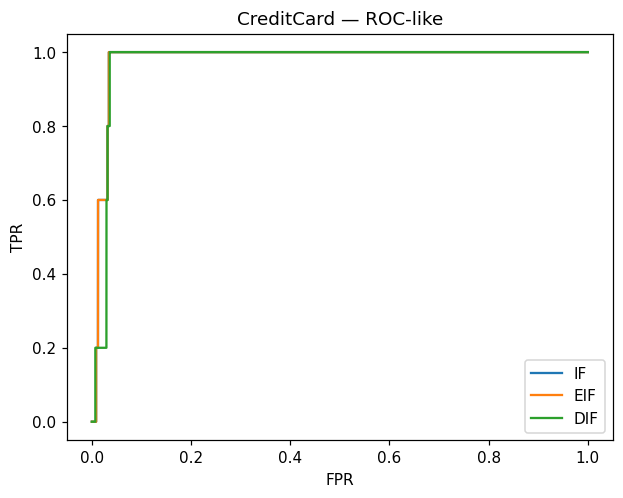

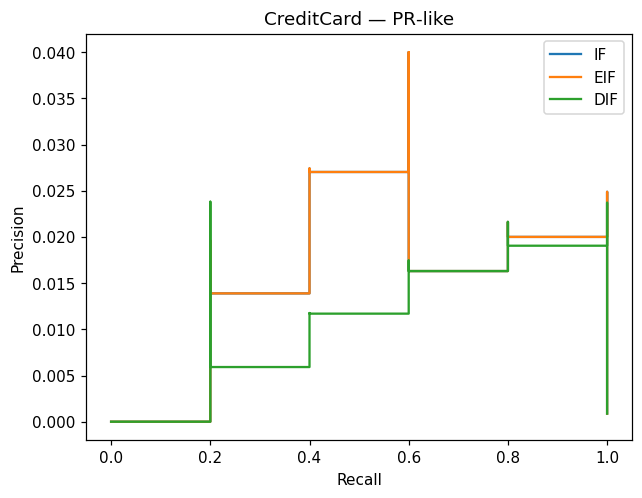

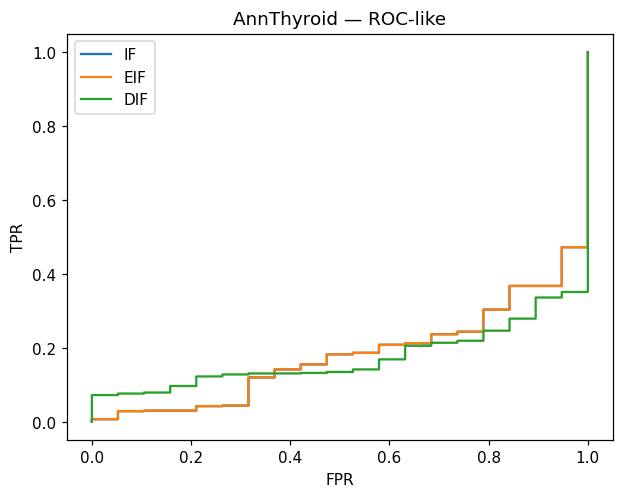

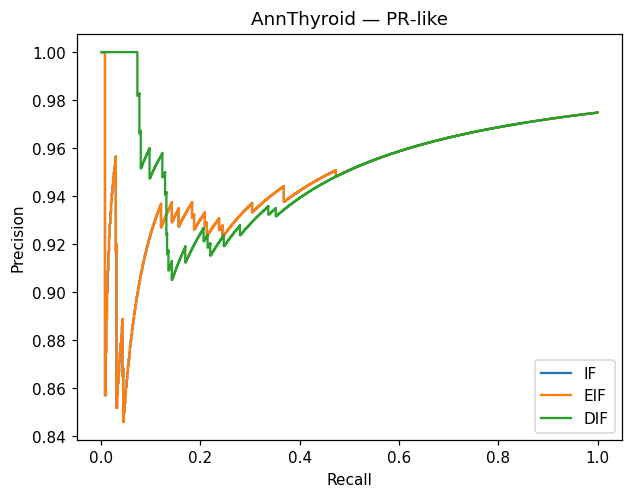

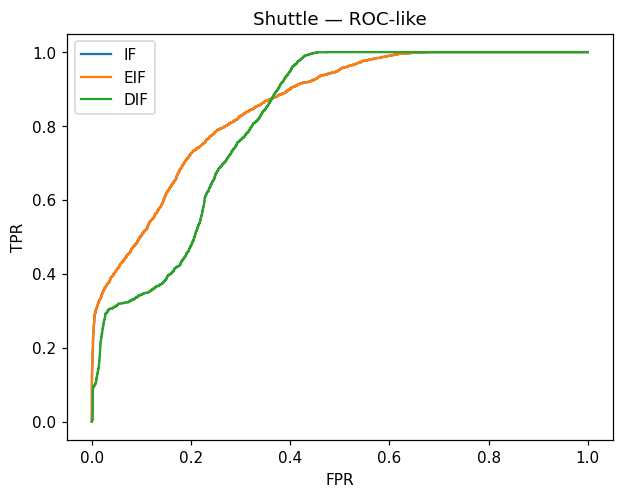

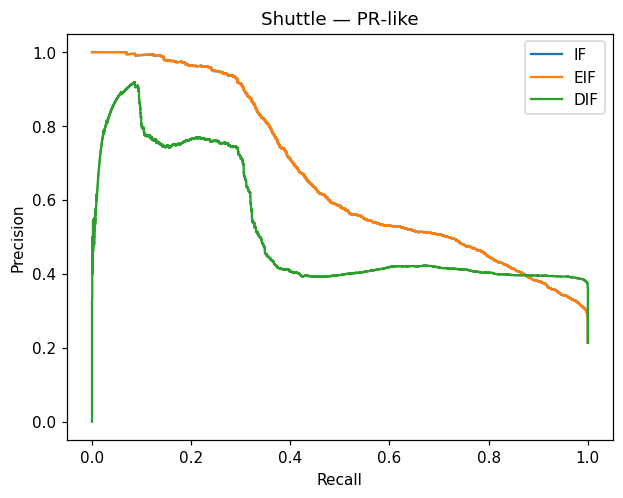

In [11]:
if 'y_cc' in globals(): plot_rank_curves(y_cc, s_cc, 'CreditCard')
if 'y_an' in globals(): plot_rank_curves(y_an, s_an, 'AnnThyroid')
if 'y_sh' in globals(): plot_rank_curves(y_sh, s_sh, 'Shuttle')


## 7. Discussion & 8. Conclusion
Isolation-based methods provide competitive baselines for anomaly detection under severe imbalance. EIF can mitigate axis-aligned artifacts; DIF may help with non-linear manifolds. Future work: calibration, cost-sensitive utility, and interpretability.

## 9. Checklist
- Literature, methods, setup, results, figures included
- Datasets: CreditCard, AnnThyroid, Shuttle (public, no credentials)
